In [55]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import tensorflow as tf
from tensorflow.keras import layers, models

# Functions 

In [56]:
def LSfitw(y,M,Sigma_inv):
    #finds beta such that ||y-M*beta||*2 is minimal but with diagonal weight
    #Sigma_inv should be Sigma^^(-1/2) so iv std matrix
    Mt = np.dot(Sigma_inv,M)
    yt = np.dot(Sigma_inv,y)
    A =np.dot(Mt.T,Mt) # this and the following steps implement the LS iversion formula
    B = np.dot(Mt.T,yt)
    betaest = np.dot(np.linalg.inv(A),B)
    yest = np.dot(M,betaest)
    return yest


def my_GLS(t,y,EB, periods):
    Sigma_inv = np.diagflat(1./EB)
    power=[]
    N = len(t)
    un = np.ones(np.shape(y)) # a vector of ones
    unt = np.dot(Sigma_inv,un)
    yt = np.dot(Sigma_inv,y)
    yest0 = (np.dot(yt,unt))/(np.dot(unt,unt))*un
    RSS0 = np.sum(((y-yest0)/EB)**2)
    for i in range(len(periods)):
        # create M0 = constant
        # create M1 = constant + sinusoid
        M1 = (np.concatenate(([un], [np.cos(2*np.pi*t/periods[i])], [np.sin(2*np.pi*t/periods[i])]), axis=0)).T # the design matric M : shape is 20 *2        
        yest1 = LSfitw(y,M1,Sigma_inv)
        RSS1 = np.sum(((y-yest1)/EB)**2)
        power.append((RSS0-RSS1)/RSS0)
    return power

def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    # VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz

           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_regular_data_H0(params_gr, params_act, N, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ts    = t*24*3600 # seconds
    ygr = lorentzian_components(params_gr, ts)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    amp, gam, logP, met  = params_act
    k  = kernels.ExpSine2Kernel(gamma=gam, log_period=logP)
    k *= kernels.ExpSquaredKernel(metric=met) # metric correspondind to r^2/lambda  is 1
    k *= amp**2 
    # print(k.get_parameter_vector())
    
    gp = george.GP(k)

    # generate synthetic dataset
    yact = gp.sample(t)
    
    # =========================================================================
    # Generate the intrincsic errors
    sig = 0.30 # m/s
    yerr = np.random.normal(loc=0, scale=sig, size=N) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors + planet if params_pl
    ytot = ygr + yact + yerr * np.random.randn(N)
    
    return ytot, yerr




def generate_planete(params_pl,t):
    """
    - params_pl
            - Ppl (Orbital period)
            - K (semi-amplitude)
            - T0 ( Phase à l'origine)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)



def print_4periodogramme(LS_p,label,freq_pl,i):
    LS = LS_p[:,i,:]
    f1,f2,f3,f4 = freq_pl[i,:]
    l1,l2,l3,l4 = label[i,:]
    
    plt.figure()
    plt.suptitle("4 Lomb-Scargle peridogramme generated by removing the best fit\n"+str(i)+" planet")
    plt.subplot(411),plt.plot(freq, LS[:,0] , label =l1), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,0]),max(LS[:,0])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,0]),max(LS[:,0])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,0]),max(LS[:,0])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,0]),max(LS[:,0])],'y--')

    plt.subplot(412), plt.plot(freq, LS[:,1] , label =l2), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,1]),max(LS[:,1])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,1]),max(LS[:,1])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,1]),max(LS[:,1])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,1]),max(LS[:,1])],'y--')

    plt.subplot(413), plt.plot(freq, LS[:,2] , label =l3), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,2]),max(LS[:,2])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,2]),max(LS[:,2])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,2]),max(LS[:,2])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,2]),max(LS[:,2])],'y--')

    plt.subplot(414 ), plt.plot(freq, LS[:,3] , label = l4), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,3]),max(LS[:,3])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,3]),max(LS[:,3])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,3]),max(LS[:,3])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,3]),max(LS[:,3])],'y--')
    
    plt.xlabel("Frequency (day⁻¹)")
    plt.ylabel("Power")
    

def generate_4_periodogrammes(t,f, y, freq_pl,nbr_planete):
    """
    Parameters
    ----------
    t : time (day)
    f : frequency ( day⁻1)
    y : original time serie

    Returns
    -------
    4 times series with their lomb-scargle 
    """
    y_t = np.zeros((len(t), 4)) #time series
    LS  = np.zeros((len(f), 4)) # 4 lombscargle 
    nbr_planete_now = np.copy(nbr_planete)
    label= np.zeros(4) #(1 if max = freq_pl, 0 else)
    max_value = np.zeros((2,4)) # (argmax, max)
    
    y_t[:,0] = y 
    
    for i in range(3):
        LS_i =  LombScargle(t, y_t[:,i])
        LS[:,i] = LS_i.power(f,method='cython')
        best_freq = round(f[np.argmax(LS[:,i])],3)
        #print("meilleur fit : ",best_freq)
        max_value[0,i], max_value[1,i] = best_freq, np.max(LS[:,i]) 
                
        if ( any(np.isclose(freq_pl, best_freq, atol=0.001)) ):
            label[i] = 1
            freq_pl[ np.where( np.isclose(freq_pl, best_freq, atol=0.001) ) ] = 0
            nbr_planete_now[i+1:] = nbr_planete_now[i] - 1
        else:
            label[i] = 0
            
        y_fit = LS_i.model(t,best_freq)
        y_t[:,i+1] = y_t[:,i] - y_fit
      
    LS_i = LombScargle(t, y_t[:,3])
    LS[:,3] = LS_i.power(f,method='cython')
    best_freq = round(f[np.argmax(LS[:,3])],3)
    #print("meilleur fit : ",best_freq)
    max_value [0,3], max_value[1,3] =  best_freq, np.max(LS[:,3])
    
    if (any(np.isclose(freq_pl, best_freq, atol=0.001))):
        label[3] = 1
        freq_pl[np.where( np.isclose(freq_pl, best_freq, atol=0.001) )] = 0
    else:
        label[3] = 0
    
    #print("label = ", label)
    
    return LS, label, max_value, nbr_planete_now     



def generate_data(t,dt,Ttot,freq,params_gr, params_act):
    
    time_series = np.zeros((len(t),5))
    LS = np.zeros((len(freq),5,4))
    freq_pl = np.zeros((5,4))
    nbr_planete = np.zeros((5,4))
    label = np.zeros((5,4))
    max_value = np.zeros((2,5,4))
    
    y_noise, yerr = generate_regular_data_H0(params_gr, params_act, len(t), t) 
    
    #print("freq planet : ",freq_pl[0,:])
    time_series[:,0] = y_noise #Without planet
    LS[:,0,:], label[0,:], max_value[:,0,:],nbr_planete[0,:] = generate_4_periodogrammes(t, freq, np.copy(y_noise), freq_pl[0,:],nbr_planete[0,:]) #Without planet
    
    for i in range(1,5):
        y_i = y_noise
        for k in range(1,i+1):
            Ppl =  random.uniform(10*dt,Ttot/2) 
            K = loguniform.rvs(0.1, 10)
            T0 =  random.uniform(0,Ppl)
            params_pl = [Ppl,K,T0]
            freq_pl[i,k-1] = round(1/Ppl,3)
            
            y_pl = generate_planete(params_pl, t)
            y_i += y_pl 
        
        
        nbr_planete[i,:] = i
        #print("freq planet : ",freq_pl[i,:])
        time_series[:,i] = y_i
        LS[:,i,:], label[i,:], max_value[:,i,:],nbr_planete[i,:] = generate_4_periodogrammes(t, freq, y_i,np.copy(freq_pl[i,:]),nbr_planete[i,:])
        
        
    return time_series, LS, label, max_value, freq_pl,nbr_planete


In [57]:
#Parameters for activity signal

# Grannulation + Oscillation
A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz

params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]

##Activity signal
Prot = 62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

amp  = gamma.rvs(2.0, 0.5) 
epsilon = uniform.rvs(0.5, 1)
tau = np.random.normal(3*Prot, 0.1*Prot) 
gam  = 2.0/epsilon #not change
logP = np.log(Prot) #not change 
met  = 1.0 # not change 

params_act = [amp, gam, logP, met]


In [58]:
#Generate time and frequency

#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days
dt = Ttot*facteur_surech/(N-1) #After sampling


# Irregular sampling 1 : with normal distribution
facteur_ech = 10
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ]
ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1] = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-2):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i+1] =  t_over[ind]
    
fmin = 1/Ttot
fmax = (1/dt)/2 
freq = np.arange(fmin,fmax,fmin/10)

In [59]:
# Function for create training/validation set. Same number of specif case ( w/o planet, 1 planet, 2 planets ...). A pourcentage 
# of 40% of positif case need to be reached

def create_set1(nbr_periodogramme, pourcentage_positive,t, dt, Ttot, freq):
    
    count_positif = 0
    count_negatif = 0
    nbr_ech = nbr_periodogramme/5
    count_ech = np.zeros(5)
    
    X_LS = []
    X_max_values = []
    Y = []
    
    start = time.time()
    
    A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #create 40% positif label
    while( count_positif < pourcentage_positive*nbr_periodogramme) :
        ##Activity signal
        Prot = 62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)

        for i in range(1,5):
            for j in range(4):
                if (label[i,j] == 1):
                    X_LS.append(LS[:,i,j])
                    X_max_values.append(max_value[:,i,j])
                    Y.append(1)
                    count_positif +=1
                    count_ech[ round(nbr_planete[i,j]) ] +=1
    
        print("Nbr positif label : ",count_positif)
        print("Nbr ech par cas de figure : ", count_ech)
        
    print("\nPositive label termined, nbr count positive label = ", count_positif)    
    print("Nbr ech par cas de figure : ", count_ech,"\n")
    nbr_planet_cas_positif = np.copy(count_ech)
    time.sleep(5)
    
    
    #create negatif label 
    while ( (count_negatif < (1-pourcentage_positive)) or (any(count_ech<nbr_ech)) ):
      
        ##Activity signal
        Prot = 62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)

        for i in range(5):
            for j in range(4):
                
                if ( (label[i,j] == 0)  and (count_ech[ round(nbr_planete[i,j]) ] < nbr_ech) ):
                        X_LS.append(LS[:,i,j])
                        X_max_values.append(max_value[:,i,j])
                        Y.append(0)
                        count_ech[ round(nbr_planete[i,j]) ] +=1
                        count_negatif += 1
                        
        print("nbr ech ",count_ech)
        print("count negatif = ",count_negatif)

    
    
    print("\nTemps total = ", round(time.time() - start,2))
    print("Nbr ech par cas de figure : ", count_ech)
    print("Nbr positive label : ",count_positif, ", Nbr negative label : ",count_negatif)
    
    print("\nRepartition label positif sur le nombre de planete : ")
    print(" - 0 planete ", 100*round(nbr_planet_cas_positif[0]/count_positif,3),"%")
    print(" - 1 planete ", 100*round(nbr_planet_cas_positif[1]/count_positif,3),"%")
    print(" - 2 planetes ", 100*round(nbr_planet_cas_positif[2]/count_positif,3),"%")
    print(" - 3 planetes ", 100*round(nbr_planet_cas_positif[3]/count_positif,3),"%")
    print(" - 4 planetes ", 100*round(nbr_planet_cas_positif[4]/count_positif,3),"%")
    
    print("Repartition label negatif sur le nombre de planete : ")
    print(" - 0 planete ", 100*round((count_ech[0]-nbr_planet_cas_positif[0])/count_negatif,3),"%")
    print(" - 1 planete ", 100*round((count_ech[1]-nbr_planet_cas_positif[1])/count_negatif,3),"%")
    print(" - 2 planetes ", 100*round((count_ech[2]-nbr_planet_cas_positif[2])/count_negatif,3),"%")
    print(" - 3 planetes ", 100*round((count_ech[3]-nbr_planet_cas_positif[3])/count_negatif,3),"%")
    print(" - 4 planetes ", 100*round((count_ech[4]-nbr_planet_cas_positif[4])/count_negatif,3),"%")
    
    print("\nRepartion classe positif/negatif : ", 100*round(count_positif/len(X_LS),2),"% , ", 100*round(count_negatif/len(X_LS),2),"%")
    
    print("\nNbr data : ", len(Y) )
    
    return X_LS, X_max_values, Y


In [60]:
#Create data for training the neural network
nbr_periodogramme_train = 13700
pourcentage_positive = 0.4
X_LS, X_max_values, Y = create_set1(nbr_periodogramme_train,pourcentage_positive,t, dt, Ttot, freq)

Nbr positif label :  6
Nbr ech par cas de figure :  [0. 1. 2. 2. 1.]
Nbr positif label :  11
Nbr ech par cas de figure :  [0. 2. 3. 4. 2.]
Nbr positif label :  17
Nbr ech par cas de figure :  [0. 3. 5. 6. 3.]
Nbr positif label :  21
Nbr ech par cas de figure :  [0. 3. 6. 8. 4.]
Nbr positif label :  26
Nbr ech par cas de figure :  [0. 4. 8. 9. 5.]
Nbr positif label :  33
Nbr ech par cas de figure :  [ 0.  5. 11. 11.  6.]
Nbr positif label :  39
Nbr ech par cas de figure :  [ 0.  6. 13. 13.  7.]
Nbr positif label :  45
Nbr ech par cas de figure :  [ 0.  8. 15. 14.  8.]
Nbr positif label :  49
Nbr ech par cas de figure :  [ 0.  9. 16. 15.  9.]
Nbr positif label :  50
Nbr ech par cas de figure :  [ 0.  9. 16. 15. 10.]
Nbr positif label :  53
Nbr ech par cas de figure :  [ 0.  9. 17. 16. 11.]
Nbr positif label :  57
Nbr ech par cas de figure :  [ 0.  9. 18. 18. 12.]
Nbr positif label :  61
Nbr ech par cas de figure :  [ 0.  9. 19. 20. 13.]
Nbr positif label :  65
Nbr ech par cas de figure :

Nbr positif label :  524
Nbr ech par cas de figure :  [  0.  97. 163. 162. 102.]
Nbr positif label :  530
Nbr ech par cas de figure :  [  0.  98. 165. 164. 103.]
Nbr positif label :  535
Nbr ech par cas de figure :  [  0.  99. 166. 166. 104.]
Nbr positif label :  540
Nbr ech par cas de figure :  [  0. 100. 168. 167. 105.]
Nbr positif label :  544
Nbr ech par cas de figure :  [  0. 100. 169. 169. 106.]
Nbr positif label :  547
Nbr ech par cas de figure :  [  0. 101. 169. 170. 107.]
Nbr positif label :  550
Nbr ech par cas de figure :  [  0. 102. 170. 170. 108.]
Nbr positif label :  555
Nbr ech par cas de figure :  [  0. 103. 172. 171. 109.]
Nbr positif label :  561
Nbr ech par cas de figure :  [  0. 105. 174. 172. 110.]
Nbr positif label :  567
Nbr ech par cas de figure :  [  0. 105. 177. 174. 111.]
Nbr positif label :  571
Nbr ech par cas de figure :  [  0. 106. 178. 175. 112.]
Nbr positif label :  577
Nbr ech par cas de figure :  [  0. 108. 179. 177. 113.]
Nbr positif label :  580
Nbr

Nbr positif label :  1019
Nbr ech par cas de figure :  [  0. 198. 305. 316. 200.]
Nbr positif label :  1023
Nbr ech par cas de figure :  [  0. 198. 306. 318. 201.]
Nbr positif label :  1028
Nbr ech par cas de figure :  [  0. 199. 308. 319. 202.]
Nbr positif label :  1034
Nbr ech par cas de figure :  [  0. 200. 310. 321. 203.]
Nbr positif label :  1040
Nbr ech par cas de figure :  [  0. 201. 312. 323. 204.]
Nbr positif label :  1044
Nbr ech par cas de figure :  [  0. 201. 313. 325. 205.]
Nbr positif label :  1044
Nbr ech par cas de figure :  [  0. 201. 313. 325. 205.]
Nbr positif label :  1048
Nbr ech par cas de figure :  [  0. 202. 314. 326. 206.]
Nbr positif label :  1052
Nbr ech par cas de figure :  [  0. 202. 315. 328. 207.]
Nbr positif label :  1056
Nbr ech par cas de figure :  [  0. 203. 316. 329. 208.]
Nbr positif label :  1060
Nbr ech par cas de figure :  [  0. 204. 316. 331. 209.]
Nbr positif label :  1066
Nbr ech par cas de figure :  [  0. 206. 318. 332. 210.]
Nbr positif labe

Nbr positif label :  1513
Nbr ech par cas de figure :  [  0. 292. 448. 476. 297.]
Nbr positif label :  1518
Nbr ech par cas de figure :  [  0. 293. 450. 477. 298.]
Nbr positif label :  1524
Nbr ech par cas de figure :  [  0. 294. 452. 479. 299.]
Nbr positif label :  1527
Nbr ech par cas de figure :  [  0. 295. 453. 480. 299.]
Nbr positif label :  1533
Nbr ech par cas de figure :  [  0. 296. 455. 482. 300.]
Nbr positif label :  1539
Nbr ech par cas de figure :  [  0. 297. 457. 484. 301.]
Nbr positif label :  1543
Nbr ech par cas de figure :  [  0. 297. 458. 486. 302.]
Nbr positif label :  1547
Nbr ech par cas de figure :  [  0. 298. 458. 488. 303.]
Nbr positif label :  1554
Nbr ech par cas de figure :  [  0. 299. 461. 490. 304.]
Nbr positif label :  1556
Nbr ech par cas de figure :  [  0. 299. 462. 490. 305.]
Nbr positif label :  1562
Nbr ech par cas de figure :  [  0. 301. 463. 492. 306.]
Nbr positif label :  1567
Nbr ech par cas de figure :  [  0. 301. 465. 494. 307.]
Nbr positif labe

Nbr positif label :  2028
Nbr ech par cas de figure :  [  0. 392. 608. 637. 391.]
Nbr positif label :  2031
Nbr ech par cas de figure :  [  0. 392. 609. 638. 392.]
Nbr positif label :  2035
Nbr ech par cas de figure :  [  0. 393. 610. 639. 393.]
Nbr positif label :  2040
Nbr ech par cas de figure :  [  0. 394. 611. 641. 394.]
Nbr positif label :  2045
Nbr ech par cas de figure :  [  0. 395. 612. 643. 395.]
Nbr positif label :  2050
Nbr ech par cas de figure :  [  0. 396. 613. 645. 396.]
Nbr positif label :  2055
Nbr ech par cas de figure :  [  0. 397. 614. 647. 397.]
Nbr positif label :  2058
Nbr ech par cas de figure :  [  0. 397. 615. 648. 398.]
Nbr positif label :  2063
Nbr ech par cas de figure :  [  0. 399. 616. 649. 399.]
Nbr positif label :  2068
Nbr ech par cas de figure :  [  0. 399. 618. 651. 400.]
Nbr positif label :  2073
Nbr ech par cas de figure :  [  0. 400. 619. 653. 401.]
Nbr positif label :  2080
Nbr ech par cas de figure :  [  0. 401. 622. 655. 402.]
Nbr positif labe

Nbr positif label :  2498
Nbr ech par cas de figure :  [  0. 485. 746. 782. 485.]
Nbr positif label :  2505
Nbr ech par cas de figure :  [  0. 486. 749. 784. 486.]
Nbr positif label :  2510
Nbr ech par cas de figure :  [  0. 487. 751. 785. 487.]
Nbr positif label :  2516
Nbr ech par cas de figure :  [  0. 488. 753. 787. 488.]
Nbr positif label :  2520
Nbr ech par cas de figure :  [  0. 488. 755. 788. 489.]
Nbr positif label :  2525
Nbr ech par cas de figure :  [  0. 489. 756. 790. 490.]
Nbr positif label :  2531
Nbr ech par cas de figure :  [  0. 490. 758. 792. 491.]
Nbr positif label :  2535
Nbr ech par cas de figure :  [  0. 490. 759. 794. 492.]
Nbr positif label :  2539
Nbr ech par cas de figure :  [  0. 490. 760. 796. 493.]
Nbr positif label :  2543
Nbr ech par cas de figure :  [  0. 490. 762. 797. 494.]
Nbr positif label :  2547
Nbr ech par cas de figure :  [  0. 491. 763. 798. 495.]
Nbr positif label :  2554
Nbr ech par cas de figure :  [  0. 493. 765. 800. 496.]
Nbr positif labe

Nbr positif label :  2980
Nbr ech par cas de figure :  [  0. 571. 901. 929. 579.]
Nbr positif label :  2985
Nbr ech par cas de figure :  [  0. 573. 903. 930. 579.]
Nbr positif label :  2990
Nbr ech par cas de figure :  [  0. 573. 905. 932. 580.]
Nbr positif label :  2994
Nbr ech par cas de figure :  [  0. 574. 906. 933. 581.]
Nbr positif label :  2998
Nbr ech par cas de figure :  [  0. 575. 906. 935. 582.]
Nbr positif label :  3000
Nbr ech par cas de figure :  [  0. 575. 906. 936. 583.]
Nbr positif label :  3005
Nbr ech par cas de figure :  [  0. 576. 907. 938. 584.]
Nbr positif label :  3011
Nbr ech par cas de figure :  [  0. 577. 909. 940. 585.]
Nbr positif label :  3016
Nbr ech par cas de figure :  [  0. 578. 910. 942. 586.]
Nbr positif label :  3020
Nbr ech par cas de figure :  [  0. 579. 911. 943. 587.]
Nbr positif label :  3022
Nbr ech par cas de figure :  [  0. 579. 911. 944. 588.]
Nbr positif label :  3027
Nbr ech par cas de figure :  [  0. 581. 912. 945. 589.]
Nbr positif labe

Nbr positif label :  3422
Nbr ech par cas de figure :  [   0.  652. 1037. 1065.  668.]
Nbr positif label :  3424
Nbr ech par cas de figure :  [   0.  652. 1037. 1066.  669.]
Nbr positif label :  3429
Nbr ech par cas de figure :  [   0.  653. 1038. 1068.  670.]
Nbr positif label :  3433
Nbr ech par cas de figure :  [   0.  654. 1039. 1069.  671.]
Nbr positif label :  3438
Nbr ech par cas de figure :  [   0.  655. 1041. 1070.  672.]
Nbr positif label :  3444
Nbr ech par cas de figure :  [   0.  656. 1043. 1072.  673.]
Nbr positif label :  3447
Nbr ech par cas de figure :  [   0.  656. 1043. 1074.  674.]
Nbr positif label :  3452
Nbr ech par cas de figure :  [   0.  657. 1045. 1075.  675.]
Nbr positif label :  3455
Nbr ech par cas de figure :  [   0.  657. 1045. 1077.  676.]
Nbr positif label :  3459
Nbr ech par cas de figure :  [   0.  658. 1046. 1078.  677.]
Nbr positif label :  3464
Nbr ech par cas de figure :  [   0.  659. 1047. 1080.  678.]
Nbr positif label :  3464
Nbr ech par cas d

Nbr positif label :  3865
Nbr ech par cas de figure :  [   0.  738. 1170. 1202.  755.]
Nbr positif label :  3868
Nbr ech par cas de figure :  [   0.  738. 1171. 1203.  756.]
Nbr positif label :  3871
Nbr ech par cas de figure :  [   0.  738. 1172. 1204.  757.]
Nbr positif label :  3876
Nbr ech par cas de figure :  [   0.  739. 1173. 1206.  758.]
Nbr positif label :  3878
Nbr ech par cas de figure :  [   0.  739. 1173. 1207.  759.]
Nbr positif label :  3882
Nbr ech par cas de figure :  [   0.  739. 1175. 1208.  760.]
Nbr positif label :  3887
Nbr ech par cas de figure :  [   0.  739. 1177. 1210.  761.]
Nbr positif label :  3892
Nbr ech par cas de figure :  [   0.  740. 1178. 1212.  762.]
Nbr positif label :  3897
Nbr ech par cas de figure :  [   0.  741. 1180. 1213.  763.]
Nbr positif label :  3902
Nbr ech par cas de figure :  [   0.  741. 1182. 1215.  764.]
Nbr positif label :  3908
Nbr ech par cas de figure :  [   0.  743. 1183. 1217.  765.]
Nbr positif label :  3913
Nbr ech par cas d

Nbr positif label :  4313
Nbr ech par cas de figure :  [   0.  827. 1300. 1341.  845.]
Nbr positif label :  4319
Nbr ech par cas de figure :  [   0.  828. 1302. 1343.  846.]
Nbr positif label :  4326
Nbr ech par cas de figure :  [   0.  830. 1304. 1345.  847.]
Nbr positif label :  4331
Nbr ech par cas de figure :  [   0.  831. 1305. 1347.  848.]
Nbr positif label :  4336
Nbr ech par cas de figure :  [   0.  833. 1306. 1348.  849.]
Nbr positif label :  4340
Nbr ech par cas de figure :  [   0.  833. 1308. 1349.  850.]
Nbr positif label :  4347
Nbr ech par cas de figure :  [   0.  835. 1310. 1351.  851.]
Nbr positif label :  4351
Nbr ech par cas de figure :  [   0.  836. 1310. 1353.  852.]
Nbr positif label :  4358
Nbr ech par cas de figure :  [   0.  838. 1312. 1355.  853.]
Nbr positif label :  4361
Nbr ech par cas de figure :  [   0.  838. 1313. 1356.  854.]
Nbr positif label :  4367
Nbr ech par cas de figure :  [   0.  839. 1315. 1358.  855.]
Nbr positif label :  4371
Nbr ech par cas d

Nbr positif label :  4750
Nbr ech par cas de figure :  [   0.  911. 1428. 1478.  933.]
Nbr positif label :  4756
Nbr ech par cas de figure :  [   0.  913. 1430. 1479.  934.]
Nbr positif label :  4760
Nbr ech par cas de figure :  [   0.  913. 1431. 1481.  935.]
Nbr positif label :  4766
Nbr ech par cas de figure :  [   0.  915. 1432. 1483.  936.]
Nbr positif label :  4770
Nbr ech par cas de figure :  [   0.  915. 1433. 1485.  937.]
Nbr positif label :  4773
Nbr ech par cas de figure :  [   0.  915. 1434. 1486.  938.]
Nbr positif label :  4778
Nbr ech par cas de figure :  [   0.  916. 1435. 1488.  939.]
Nbr positif label :  4783
Nbr ech par cas de figure :  [   0.  917. 1436. 1490.  940.]
Nbr positif label :  4786
Nbr ech par cas de figure :  [   0.  917. 1437. 1491.  941.]
Nbr positif label :  4791
Nbr ech par cas de figure :  [   0.  917. 1439. 1493.  942.]
Nbr positif label :  4797
Nbr ech par cas de figure :  [   0.  918. 1441. 1495.  943.]
Nbr positif label :  4801
Nbr ech par cas d

Nbr positif label :  5187
Nbr ech par cas de figure :  [   0.  987. 1555. 1620. 1025.]
Nbr positif label :  5190
Nbr ech par cas de figure :  [   0.  988. 1556. 1621. 1025.]
Nbr positif label :  5195
Nbr ech par cas de figure :  [   0.  989. 1557. 1623. 1026.]
Nbr positif label :  5200
Nbr ech par cas de figure :  [   0.  991. 1559. 1624. 1026.]
Nbr positif label :  5204
Nbr ech par cas de figure :  [   0.  991. 1561. 1625. 1027.]
Nbr positif label :  5210
Nbr ech par cas de figure :  [   0.  992. 1563. 1627. 1028.]
Nbr positif label :  5216
Nbr ech par cas de figure :  [   0.  994. 1564. 1629. 1029.]
Nbr positif label :  5218
Nbr ech par cas de figure :  [   0.  995. 1564. 1630. 1029.]
Nbr positif label :  5222
Nbr ech par cas de figure :  [   0.  995. 1565. 1632. 1030.]
Nbr positif label :  5228
Nbr ech par cas de figure :  [   0.  996. 1567. 1634. 1031.]
Nbr positif label :  5235
Nbr ech par cas de figure :  [   0.  998. 1569. 1636. 1032.]
Nbr positif label :  5242
Nbr ech par cas d

nbr ech  [ 267. 1239. 1767. 1787. 1136.]
count negatif =  714
nbr ech  [ 271. 1243. 1773. 1791. 1136.]
count negatif =  732
nbr ech  [ 276. 1250. 1773. 1791. 1138.]
count negatif =  746
nbr ech  [ 280. 1257. 1773. 1794. 1139.]
count negatif =  761
nbr ech  [ 284. 1266. 1773. 1794. 1143.]
count negatif =  778
nbr ech  [ 288. 1275. 1775. 1794. 1143.]
count negatif =  793
nbr ech  [ 292. 1282. 1780. 1794. 1143.]
count negatif =  809
nbr ech  [ 299. 1282. 1786. 1796. 1143.]
count negatif =  824
nbr ech  [ 305. 1286. 1786. 1803. 1143.]
count negatif =  841
nbr ech  [ 312. 1286. 1793. 1804. 1144.]
count negatif =  857
nbr ech  [ 319. 1288. 1795. 1806. 1144.]
count negatif =  870
nbr ech  [ 326. 1292. 1798. 1806. 1144.]
count negatif =  884
nbr ech  [ 333. 1292. 1802. 1810. 1147.]
count negatif =  902
nbr ech  [ 337. 1300. 1805. 1810. 1147.]
count negatif =  917
nbr ech  [ 344. 1305. 1805. 1810. 1150.]
count negatif =  932
nbr ech  [ 350. 1308. 1810. 1810. 1150.]
count negatif =  946
nbr ech 

nbr ech  [1060. 1761. 2121. 2028. 1222.]
count negatif =  2710
nbr ech  [1068. 1761. 2122. 2034. 1223.]
count negatif =  2726
nbr ech  [1075. 1763. 2125. 2038. 1223.]
count negatif =  2742
nbr ech  [1084. 1765. 2127. 2038. 1223.]
count negatif =  2755
nbr ech  [1089. 1773. 2127. 2038. 1223.]
count negatif =  2768
nbr ech  [1094. 1779. 2128. 2039. 1223.]
count negatif =  2781
nbr ech  [1100. 1783. 2131. 2040. 1225.]
count negatif =  2797
nbr ech  [1107. 1786. 2131. 2042. 1227.]
count negatif =  2811
nbr ech  [1112. 1790. 2135. 2044. 1227.]
count negatif =  2826
nbr ech  [1117. 1796. 2136. 2044. 1229.]
count negatif =  2840
nbr ech  [1121. 1803. 2139. 2046. 1229.]
count negatif =  2856
nbr ech  [1127. 1808. 2140. 2049. 1229.]
count negatif =  2871
nbr ech  [1134. 1811. 2141. 2049. 1230.]
count negatif =  2883
nbr ech  [1141. 1814. 2142. 2049. 1231.]
count negatif =  2895
nbr ech  [1148. 1816. 2143. 2055. 1231.]
count negatif =  2911
nbr ech  [1155. 1819. 2145. 2056. 1233.]
count negatif 

nbr ech  [1847. 2298. 2454. 2260. 1315.]
count negatif =  4692
nbr ech  [1851. 2304. 2460. 2260. 1315.]
count negatif =  4708
nbr ech  [1858. 2307. 2463. 2263. 1315.]
count negatif =  4724
nbr ech  [1865. 2308. 2468. 2265. 1315.]
count negatif =  4739
nbr ech  [1872. 2311. 2470. 2267. 1315.]
count negatif =  4753
nbr ech  [1878. 2317. 2470. 2267. 1319.]
count negatif =  4769
nbr ech  [1882. 2326. 2470. 2268. 1321.]
count negatif =  4785
nbr ech  [1890. 2329. 2470. 2270. 1321.]
count negatif =  4798
nbr ech  [1897. 2332. 2475. 2270. 1321.]
count negatif =  4813
nbr ech  [1904. 2335. 2476. 2272. 1324.]
count negatif =  4829
nbr ech  [1911. 2338. 2478. 2274. 1324.]
count negatif =  4843
nbr ech  [1915. 2342. 2486. 2275. 1324.]
count negatif =  4860
nbr ech  [1919. 2349. 2490. 2275. 1325.]
count negatif =  4876
nbr ech  [1926. 2352. 2493. 2278. 1325.]
count negatif =  4892
nbr ech  [1930. 2356. 2502. 2278. 1325.]
count negatif =  4909
nbr ech  [1934. 2363. 2507. 2278. 1325.]
count negatif 

nbr ech  [2619. 2740. 2740. 2462. 1417.]
count negatif =  6496
nbr ech  [2623. 2740. 2740. 2465. 1417.]
count negatif =  6503
nbr ech  [2630. 2740. 2740. 2467. 1418.]
count negatif =  6513
nbr ech  [2637. 2740. 2740. 2469. 1418.]
count negatif =  6522
nbr ech  [2641. 2740. 2740. 2473. 1418.]
count negatif =  6530
nbr ech  [2647. 2740. 2740. 2474. 1420.]
count negatif =  6539
nbr ech  [2654. 2740. 2740. 2475. 1420.]
count negatif =  6547
nbr ech  [2661. 2740. 2740. 2475. 1420.]
count negatif =  6554
nbr ech  [2665. 2740. 2740. 2476. 1420.]
count negatif =  6559
nbr ech  [2669. 2740. 2740. 2476. 1423.]
count negatif =  6566
nbr ech  [2673. 2740. 2740. 2478. 1424.]
count negatif =  6573
nbr ech  [2680. 2740. 2740. 2478. 1424.]
count negatif =  6580
nbr ech  [2687. 2740. 2740. 2485. 1424.]
count negatif =  6594
nbr ech  [2691. 2740. 2740. 2485. 1428.]
count negatif =  6602
nbr ech  [2700. 2740. 2740. 2485. 1428.]
count negatif =  6611
nbr ech  [2704. 2740. 2740. 2486. 1431.]
count negatif 

nbr ech  [2740. 2740. 2740. 2680. 1518.]
count negatif =  6936
nbr ech  [2740. 2740. 2740. 2680. 1518.]
count negatif =  6936
nbr ech  [2740. 2740. 2740. 2681. 1519.]
count negatif =  6938
nbr ech  [2740. 2740. 2740. 2682. 1521.]
count negatif =  6941
nbr ech  [2740. 2740. 2740. 2683. 1525.]
count negatif =  6946
nbr ech  [2740. 2740. 2740. 2683. 1525.]
count negatif =  6946
nbr ech  [2740. 2740. 2740. 2686. 1525.]
count negatif =  6949
nbr ech  [2740. 2740. 2740. 2689. 1525.]
count negatif =  6952
nbr ech  [2740. 2740. 2740. 2696. 1525.]
count negatif =  6959
nbr ech  [2740. 2740. 2740. 2699. 1525.]
count negatif =  6962
nbr ech  [2740. 2740. 2740. 2700. 1525.]
count negatif =  6963
nbr ech  [2740. 2740. 2740. 2703. 1526.]
count negatif =  6967
nbr ech  [2740. 2740. 2740. 2707. 1530.]
count negatif =  6975
nbr ech  [2740. 2740. 2740. 2709. 1531.]
count negatif =  6978
nbr ech  [2740. 2740. 2740. 2709. 1532.]
count negatif =  6979
nbr ech  [2740. 2740. 2740. 2712. 1532.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1632.]
count negatif =  7110
nbr ech  [2740. 2740. 2740. 2740. 1634.]
count negatif =  7112
nbr ech  [2740. 2740. 2740. 2740. 1635.]
count negatif =  7113
nbr ech  [2740. 2740. 2740. 2740. 1635.]
count negatif =  7113
nbr ech  [2740. 2740. 2740. 2740. 1635.]
count negatif =  7113
nbr ech  [2740. 2740. 2740. 2740. 1638.]
count negatif =  7116
nbr ech  [2740. 2740. 2740. 2740. 1638.]
count negatif =  7116
nbr ech  [2740. 2740. 2740. 2740. 1638.]
count negatif =  7116
nbr ech  [2740. 2740. 2740. 2740. 1639.]
count negatif =  7117
nbr ech  [2740. 2740. 2740. 2740. 1639.]
count negatif =  7117
nbr ech  [2740. 2740. 2740. 2740. 1639.]
count negatif =  7117
nbr ech  [2740. 2740. 2740. 2740. 1639.]
count negatif =  7117
nbr ech  [2740. 2740. 2740. 2740. 1639.]
count negatif =  7117
nbr ech  [2740. 2740. 2740. 2740. 1639.]
count negatif =  7117
nbr ech  [2740. 2740. 2740. 2740. 1639.]
count negatif =  7117
nbr ech  [2740. 2740. 2740. 2740. 1639.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1714.]
count negatif =  7192
nbr ech  [2740. 2740. 2740. 2740. 1714.]
count negatif =  7192
nbr ech  [2740. 2740. 2740. 2740. 1716.]
count negatif =  7194
nbr ech  [2740. 2740. 2740. 2740. 1716.]
count negatif =  7194
nbr ech  [2740. 2740. 2740. 2740. 1717.]
count negatif =  7195
nbr ech  [2740. 2740. 2740. 2740. 1717.]
count negatif =  7195
nbr ech  [2740. 2740. 2740. 2740. 1718.]
count negatif =  7196
nbr ech  [2740. 2740. 2740. 2740. 1719.]
count negatif =  7197
nbr ech  [2740. 2740. 2740. 2740. 1719.]
count negatif =  7197
nbr ech  [2740. 2740. 2740. 2740. 1719.]
count negatif =  7197
nbr ech  [2740. 2740. 2740. 2740. 1719.]
count negatif =  7197
nbr ech  [2740. 2740. 2740. 2740. 1721.]
count negatif =  7199
nbr ech  [2740. 2740. 2740. 2740. 1721.]
count negatif =  7199
nbr ech  [2740. 2740. 2740. 2740. 1721.]
count negatif =  7199
nbr ech  [2740. 2740. 2740. 2740. 1721.]
count negatif =  7199
nbr ech  [2740. 2740. 2740. 2740. 1722.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1807.]
count negatif =  7285
nbr ech  [2740. 2740. 2740. 2740. 1807.]
count negatif =  7285
nbr ech  [2740. 2740. 2740. 2740. 1807.]
count negatif =  7285
nbr ech  [2740. 2740. 2740. 2740. 1807.]
count negatif =  7285
nbr ech  [2740. 2740. 2740. 2740. 1807.]
count negatif =  7285
nbr ech  [2740. 2740. 2740. 2740. 1807.]
count negatif =  7285
nbr ech  [2740. 2740. 2740. 2740. 1808.]
count negatif =  7286
nbr ech  [2740. 2740. 2740. 2740. 1808.]
count negatif =  7286
nbr ech  [2740. 2740. 2740. 2740. 1808.]
count negatif =  7286
nbr ech  [2740. 2740. 2740. 2740. 1810.]
count negatif =  7288
nbr ech  [2740. 2740. 2740. 2740. 1811.]
count negatif =  7289
nbr ech  [2740. 2740. 2740. 2740. 1812.]
count negatif =  7290
nbr ech  [2740. 2740. 2740. 2740. 1813.]
count negatif =  7291
nbr ech  [2740. 2740. 2740. 2740. 1813.]
count negatif =  7291
nbr ech  [2740. 2740. 2740. 2740. 1813.]
count negatif =  7291
nbr ech  [2740. 2740. 2740. 2740. 1813.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1905.]
count negatif =  7383
nbr ech  [2740. 2740. 2740. 2740. 1905.]
count negatif =  7383
nbr ech  [2740. 2740. 2740. 2740. 1907.]
count negatif =  7385
nbr ech  [2740. 2740. 2740. 2740. 1907.]
count negatif =  7385
nbr ech  [2740. 2740. 2740. 2740. 1909.]
count negatif =  7387
nbr ech  [2740. 2740. 2740. 2740. 1910.]
count negatif =  7388
nbr ech  [2740. 2740. 2740. 2740. 1910.]
count negatif =  7388
nbr ech  [2740. 2740. 2740. 2740. 1910.]
count negatif =  7388
nbr ech  [2740. 2740. 2740. 2740. 1910.]
count negatif =  7388
nbr ech  [2740. 2740. 2740. 2740. 1910.]
count negatif =  7388
nbr ech  [2740. 2740. 2740. 2740. 1910.]
count negatif =  7388
nbr ech  [2740. 2740. 2740. 2740. 1911.]
count negatif =  7389
nbr ech  [2740. 2740. 2740. 2740. 1912.]
count negatif =  7390
nbr ech  [2740. 2740. 2740. 2740. 1912.]
count negatif =  7390
nbr ech  [2740. 2740. 2740. 2740. 1912.]
count negatif =  7390
nbr ech  [2740. 2740. 2740. 2740. 1912.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1978.]
count negatif =  7456
nbr ech  [2740. 2740. 2740. 2740. 1978.]
count negatif =  7456
nbr ech  [2740. 2740. 2740. 2740. 1978.]
count negatif =  7456
nbr ech  [2740. 2740. 2740. 2740. 1979.]
count negatif =  7457
nbr ech  [2740. 2740. 2740. 2740. 1979.]
count negatif =  7457
nbr ech  [2740. 2740. 2740. 2740. 1980.]
count negatif =  7458
nbr ech  [2740. 2740. 2740. 2740. 1984.]
count negatif =  7462
nbr ech  [2740. 2740. 2740. 2740. 1988.]
count negatif =  7466
nbr ech  [2740. 2740. 2740. 2740. 1990.]
count negatif =  7468
nbr ech  [2740. 2740. 2740. 2740. 1991.]
count negatif =  7469
nbr ech  [2740. 2740. 2740. 2740. 1991.]
count negatif =  7469
nbr ech  [2740. 2740. 2740. 2740. 1991.]
count negatif =  7469
nbr ech  [2740. 2740. 2740. 2740. 1992.]
count negatif =  7470
nbr ech  [2740. 2740. 2740. 2740. 1992.]
count negatif =  7470
nbr ech  [2740. 2740. 2740. 2740. 1993.]
count negatif =  7471
nbr ech  [2740. 2740. 2740. 2740. 1993.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2066.]
count negatif =  7544
nbr ech  [2740. 2740. 2740. 2740. 2066.]
count negatif =  7544
nbr ech  [2740. 2740. 2740. 2740. 2067.]
count negatif =  7545
nbr ech  [2740. 2740. 2740. 2740. 2067.]
count negatif =  7545
nbr ech  [2740. 2740. 2740. 2740. 2070.]
count negatif =  7548
nbr ech  [2740. 2740. 2740. 2740. 2070.]
count negatif =  7548
nbr ech  [2740. 2740. 2740. 2740. 2071.]
count negatif =  7549
nbr ech  [2740. 2740. 2740. 2740. 2072.]
count negatif =  7550
nbr ech  [2740. 2740. 2740. 2740. 2073.]
count negatif =  7551
nbr ech  [2740. 2740. 2740. 2740. 2073.]
count negatif =  7551
nbr ech  [2740. 2740. 2740. 2740. 2075.]
count negatif =  7553
nbr ech  [2740. 2740. 2740. 2740. 2076.]
count negatif =  7554
nbr ech  [2740. 2740. 2740. 2740. 2080.]
count negatif =  7558
nbr ech  [2740. 2740. 2740. 2740. 2080.]
count negatif =  7558
nbr ech  [2740. 2740. 2740. 2740. 2080.]
count negatif =  7558
nbr ech  [2740. 2740. 2740. 2740. 2081.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2165.]
count negatif =  7643
nbr ech  [2740. 2740. 2740. 2740. 2165.]
count negatif =  7643
nbr ech  [2740. 2740. 2740. 2740. 2165.]
count negatif =  7643
nbr ech  [2740. 2740. 2740. 2740. 2165.]
count negatif =  7643
nbr ech  [2740. 2740. 2740. 2740. 2165.]
count negatif =  7643
nbr ech  [2740. 2740. 2740. 2740. 2169.]
count negatif =  7647
nbr ech  [2740. 2740. 2740. 2740. 2171.]
count negatif =  7649
nbr ech  [2740. 2740. 2740. 2740. 2171.]
count negatif =  7649
nbr ech  [2740. 2740. 2740. 2740. 2171.]
count negatif =  7649
nbr ech  [2740. 2740. 2740. 2740. 2172.]
count negatif =  7650
nbr ech  [2740. 2740. 2740. 2740. 2172.]
count negatif =  7650
nbr ech  [2740. 2740. 2740. 2740. 2172.]
count negatif =  7650
nbr ech  [2740. 2740. 2740. 2740. 2174.]
count negatif =  7652
nbr ech  [2740. 2740. 2740. 2740. 2174.]
count negatif =  7652
nbr ech  [2740. 2740. 2740. 2740. 2176.]
count negatif =  7654
nbr ech  [2740. 2740. 2740. 2740. 2177.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2243.]
count negatif =  7721
nbr ech  [2740. 2740. 2740. 2740. 2244.]
count negatif =  7722
nbr ech  [2740. 2740. 2740. 2740. 2244.]
count negatif =  7722
nbr ech  [2740. 2740. 2740. 2740. 2244.]
count negatif =  7722
nbr ech  [2740. 2740. 2740. 2740. 2244.]
count negatif =  7722
nbr ech  [2740. 2740. 2740. 2740. 2245.]
count negatif =  7723
nbr ech  [2740. 2740. 2740. 2740. 2246.]
count negatif =  7724
nbr ech  [2740. 2740. 2740. 2740. 2247.]
count negatif =  7725
nbr ech  [2740. 2740. 2740. 2740. 2247.]
count negatif =  7725
nbr ech  [2740. 2740. 2740. 2740. 2247.]
count negatif =  7725
nbr ech  [2740. 2740. 2740. 2740. 2248.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2248.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2248.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2248.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2248.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2250.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2349.]
count negatif =  7827
nbr ech  [2740. 2740. 2740. 2740. 2349.]
count negatif =  7827
nbr ech  [2740. 2740. 2740. 2740. 2353.]
count negatif =  7831
nbr ech  [2740. 2740. 2740. 2740. 2353.]
count negatif =  7831
nbr ech  [2740. 2740. 2740. 2740. 2355.]
count negatif =  7833
nbr ech  [2740. 2740. 2740. 2740. 2355.]
count negatif =  7833
nbr ech  [2740. 2740. 2740. 2740. 2356.]
count negatif =  7834
nbr ech  [2740. 2740. 2740. 2740. 2357.]
count negatif =  7835
nbr ech  [2740. 2740. 2740. 2740. 2357.]
count negatif =  7835
nbr ech  [2740. 2740. 2740. 2740. 2359.]
count negatif =  7837
nbr ech  [2740. 2740. 2740. 2740. 2360.]
count negatif =  7838
nbr ech  [2740. 2740. 2740. 2740. 2360.]
count negatif =  7838
nbr ech  [2740. 2740. 2740. 2740. 2360.]
count negatif =  7838
nbr ech  [2740. 2740. 2740. 2740. 2360.]
count negatif =  7838
nbr ech  [2740. 2740. 2740. 2740. 2362.]
count negatif =  7840
nbr ech  [2740. 2740. 2740. 2740. 2363.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2451.]
count negatif =  7929
nbr ech  [2740. 2740. 2740. 2740. 2453.]
count negatif =  7931
nbr ech  [2740. 2740. 2740. 2740. 2457.]
count negatif =  7935
nbr ech  [2740. 2740. 2740. 2740. 2458.]
count negatif =  7936
nbr ech  [2740. 2740. 2740. 2740. 2458.]
count negatif =  7936
nbr ech  [2740. 2740. 2740. 2740. 2462.]
count negatif =  7940
nbr ech  [2740. 2740. 2740. 2740. 2463.]
count negatif =  7941
nbr ech  [2740. 2740. 2740. 2740. 2463.]
count negatif =  7941
nbr ech  [2740. 2740. 2740. 2740. 2463.]
count negatif =  7941
nbr ech  [2740. 2740. 2740. 2740. 2464.]
count negatif =  7942
nbr ech  [2740. 2740. 2740. 2740. 2464.]
count negatif =  7942
nbr ech  [2740. 2740. 2740. 2740. 2468.]
count negatif =  7946
nbr ech  [2740. 2740. 2740. 2740. 2469.]
count negatif =  7947
nbr ech  [2740. 2740. 2740. 2740. 2469.]
count negatif =  7947
nbr ech  [2740. 2740. 2740. 2740. 2471.]
count negatif =  7949
nbr ech  [2740. 2740. 2740. 2740. 2471.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2569.]
count negatif =  8047
nbr ech  [2740. 2740. 2740. 2740. 2570.]
count negatif =  8048
nbr ech  [2740. 2740. 2740. 2740. 2572.]
count negatif =  8050
nbr ech  [2740. 2740. 2740. 2740. 2576.]
count negatif =  8054
nbr ech  [2740. 2740. 2740. 2740. 2577.]
count negatif =  8055
nbr ech  [2740. 2740. 2740. 2740. 2580.]
count negatif =  8058
nbr ech  [2740. 2740. 2740. 2740. 2580.]
count negatif =  8058
nbr ech  [2740. 2740. 2740. 2740. 2580.]
count negatif =  8058
nbr ech  [2740. 2740. 2740. 2740. 2580.]
count negatif =  8058
nbr ech  [2740. 2740. 2740. 2740. 2580.]
count negatif =  8058
nbr ech  [2740. 2740. 2740. 2740. 2583.]
count negatif =  8061
nbr ech  [2740. 2740. 2740. 2740. 2584.]
count negatif =  8062
nbr ech  [2740. 2740. 2740. 2740. 2585.]
count negatif =  8063
nbr ech  [2740. 2740. 2740. 2740. 2585.]
count negatif =  8063
nbr ech  [2740. 2740. 2740. 2740. 2585.]
count negatif =  8063
nbr ech  [2740. 2740. 2740. 2740. 2585.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2682.]
count negatif =  8160
nbr ech  [2740. 2740. 2740. 2740. 2683.]
count negatif =  8161
nbr ech  [2740. 2740. 2740. 2740. 2683.]
count negatif =  8161
nbr ech  [2740. 2740. 2740. 2740. 2683.]
count negatif =  8161
nbr ech  [2740. 2740. 2740. 2740. 2683.]
count negatif =  8161
nbr ech  [2740. 2740. 2740. 2740. 2683.]
count negatif =  8161
nbr ech  [2740. 2740. 2740. 2740. 2683.]
count negatif =  8161
nbr ech  [2740. 2740. 2740. 2740. 2683.]
count negatif =  8161
nbr ech  [2740. 2740. 2740. 2740. 2684.]
count negatif =  8162
nbr ech  [2740. 2740. 2740. 2740. 2684.]
count negatif =  8162
nbr ech  [2740. 2740. 2740. 2740. 2685.]
count negatif =  8163
nbr ech  [2740. 2740. 2740. 2740. 2685.]
count negatif =  8163
nbr ech  [2740. 2740. 2740. 2740. 2685.]
count negatif =  8163
nbr ech  [2740. 2740. 2740. 2740. 2685.]
count negatif =  8163
nbr ech  [2740. 2740. 2740. 2740. 2688.]
count negatif =  8166
nbr ech  [2740. 2740. 2740. 2740. 2691.]
count negatif 

In [61]:
N_data = len(X_LS)
print("X_lS : ", len(X_LS), type(X_LS))
print("X_max_values : ", len(X_max_values), type(X_max_values))

print("\n1 periodogramme : ",len(X_LS[0]), type(X_LS[0]) ) #periodogramme
print("1 max values : ", len(X_max_values[0]), type(X_max_values[0]) ) #max values 

print("Y : ", len(Y), type(Y))

X_lS :  13700 <class 'list'>
X_max_values :  13700 <class 'list'>

1 periodogramme :  990 <class 'numpy.ndarray'>
1 max values :  2 <class 'numpy.ndarray'>
Y :  13700 <class 'list'>


In [69]:
#Data pre-processing 

#shuffle
c = list(zip(X_LS, X_max_values,Y))
random.shuffle(c)
X_LS, X_max_values,Y = zip(*c)

#Periodogramme
X1 = tf.convert_to_tensor(X_LS, dtype= 'float32')
X_shape =  [N_data,len(X_LS[0]), 1]
X1 = tf.reshape(X1, X_shape )

#Max values
X2 = tf.convert_to_tensor(X_max_values, dtype= 'float32')
X2 = tf.reshape(X2, (N_data, 2,1))

#Label
Y = tf.convert_to_tensor(Y)
Y = tf.reshape(Y, (N_data,1 ))

#Split train/validation
X_train1, X_test1 = X1[0:10000, :, :], X1[10000:, :, :]
X_train2,X_test2 = X2[0:10000, :, :], X2[10000:, :, :]
Y_train, Y_test = Y[0:10000], Y[10000:,:]

print("Periodogramme train size : ", X_train1.shape)
print("Periodogramme test size : ", X_test1.shape)
print("\n")
print("Max_values train size : ", X_train2.shape)
print("Max_values test size : ", X_test2.shape)
print("\n")
print("Label train size : ", Y_train.shape)
print("Label test size : ", Y_test.shape)

Periodogramme train size :  (10000, 990, 1)
Periodogramme test size :  (3700, 990, 1)


Max_values train size :  (10000, 2, 1)
Max_values test size :  (3700, 2, 1)


Label train size :  (10000, 1)
Label test size :  (3700, 1)




In [70]:
#Model with functional API Keras

#periodogramme as input to a CNN
inputs1 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1,
                   activation='relu', use_bias = True,input_shape= (990,))(inputs1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6, activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8, activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs1 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs2 = tf.keras.Input(shape=(2,))
outputs2 = layers.Dense(2, activation = 'relu')(inputs2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs1, outputs2])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

In [71]:
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET")

In [72]:
model.summary()

Model: "ExoplANNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 990, 1)]     0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 989, 32)      96          ['input_14[0][0]']               
                                                                                                  
 max_pooling1d_18 (MaxPooling1D  (None, 494, 32)     0           ['conv1d_18[0][0]']              
 )                                                                                                
                                                                                                  
 conv1d_19 (Conv1D)             (None, 489, 32)      6176        ['max_pooling1d_18[0][0]

In [73]:
#Create metrics
from tensorflow.keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    predicted_positives = K.sum( K.round(K.clip(y_pred,0,1)) )
    return true_positives / ( predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    real_positives = K.sum( K.round(K.clip(y_true,0,1)) )
    return true_positives / (real_positives + K.epsilon())

def f_score(y_true, y_pred):
    P = precision_m(y_true, y_pred)
    R = recall_m(y_true, y_pred)
    return (2*P*R) / (P+R)


In [74]:
#Train the network

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              metrics =['accuracy',precision_m, recall_m, f_score])

start = time.time()
history = model.fit(x = [X_train1, X_train2], y = Y_train, batch_size = 128, epochs = 50, 
                    verbose = 1, callbacks=[early_stopping])
time_train = time.time() - start

Epoch 1/50
79/79 [==============================] - 10s 114ms/step - loss: 0.5700 - accuracy: 0.6905 - precision_m: 0.5870 - recall_m: 0.5480 - f_score: nan
Epoch 2/50
79/79 [==============================] - 11s 134ms/step - loss: 0.5082 - accuracy: 0.7341 - precision_m: 0.6432 - recall_m: 0.7608 - f_score: 0.6954
Epoch 3/50
79/79 [==============================] - 9s 115ms/step - loss: 0.4894 - accuracy: 0.7461 - precision_m: 0.6512 - recall_m: 0.8098 - f_score: 0.7196
Epoch 4/50
79/79 [==============================] - 10s 124ms/step - loss: 0.4805 - accuracy: 0.7478 - precision_m: 0.6491 - recall_m: 0.8089 - f_score: 0.7175
Epoch 5/50
79/79 [==============================] - 12s 146ms/step - loss: 0.4672 - accuracy: 0.7602 - precision_m: 0.6657 - recall_m: 0.8091 - f_score: 0.7279
Epoch 6/50
79/79 [==============================] - 10s 132ms/step - loss: 0.4596 - accuracy: 0.7625 - precision_m: 0.6775 - recall_m: 0.7829 - f_score: 0.7233
Epoch 7/50
79/79 [==========================

Temps d'entrainement :  563.4593827724457  s


Text(0.5, 0, 'Epochs')

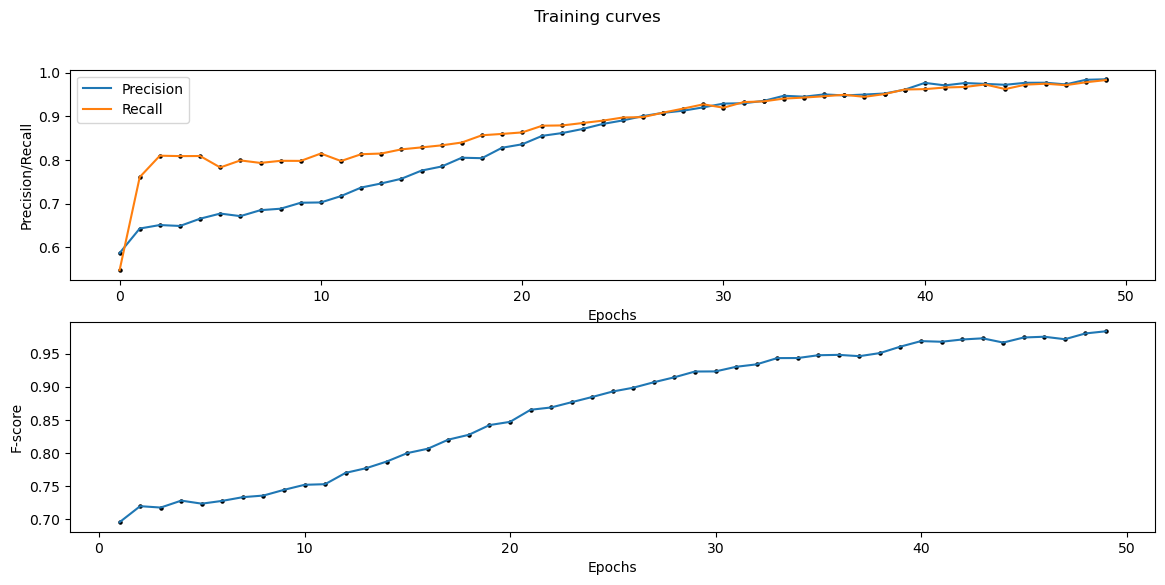

In [92]:
print("Temps d'entrainement : ", time_train, " s")

x = np.arange(50)

plt.figure(figsize=(14,6))
plt.suptitle(" Training curves")
plt.subplot(211)
plt.scatter(x,history.history['precision_m'], s=5, c='k')
plt.plot(history.history['precision_m'],label='Precision'), plt.legend()

plt.scatter(x,history.history['recall_m'], s=5, c='k')
plt.plot(history.history['recall_m'], label='Recall'), plt.legend()

plt.ylabel("Precision/Recall")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(history.history['f_score'])
plt.ylabel("F-score")
plt.xlabel("Epochs")

In [97]:
#validation 
score = model.evaluate( x =[X_test1, X_test2], y =Y_test)
print("Test F-score = ", 100*round(score[-1],4),"%")

116/116 [==============================] - 5s 43ms/step - loss: 0.8196 - accuracy: 0.8578 - precision_m: 0.8072 - recall_m: 0.8434 - f_score: 0.8172
Test F-score =  81.72 %
